# Multivariate Linear Regression 수행하기
- feature의 갯수가 많을때, 즉 독립변수가 2개 이상일때 다변량회귀를 사용하여 regrssion을 수행한다.

In [0]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf 
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

In [0]:
# boston dataset 가져오기
boston = load_boston()
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [0]:
boston_df = pd.DataFrame(boston['data'],
                         columns=boston['feature_names'])
boston_df['house_price'] = boston['target']
boston_df.head(10)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,house_price
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


### 데이터 분포확인

In [0]:
max_value = boston_df.max()
min_value = boston_df.min()
min_value # 각 Feature 별 최솟값

CRIM             0.00632
ZN               0.00000
INDUS            0.46000
CHAS             0.00000
NOX              0.38500
RM               3.56100
AGE              2.90000
DIS              1.12960
RAD              1.00000
TAX            187.00000
PTRATIO         12.60000
B                0.32000
LSTAT            1.73000
house_price      5.00000
dtype: float64

### Min-Max scaling 수행

In [0]:
minmax_df = (boston_df - min_value)/(max_value-min_value)
minmax_df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,house_price
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,0.040544,0.113636,0.391378,0.069170,0.349167,0.521869,0.676364,0.242381,0.371713,0.422208,0.622929,0.898568,0.301409,0.389618
std,0.096679,0.233225,0.251479,0.253994,0.238431,0.134627,0.289896,0.191482,0.378576,0.321636,0.230313,0.230205,0.197049,0.204380
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000851,0.000000,0.173387,0.000000,0.131687,0.445392,0.433831,0.088259,0.130435,0.175573,0.510638,0.945730,0.144040,0.267222
50%,0.002812,0.000000,0.338343,0.000000,0.314815,0.507281,0.768280,0.188949,0.173913,0.272901,0.686170,0.986232,0.265728,0.360000
75%,0.041258,0.125000,0.646628,0.000000,0.491770,0.586798,0.938980,0.369088,1.000000,0.914122,0.808511,0.998298,0.420116,0.444444
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### (1) 손실 함수 정의
$$
Loss(W) = \frac{1}{2m}\sum_{i=1}^{m}(\hat y - y)^2 = \frac{1}{2m}\sum_{i=1}^{m}(X^{(i)} \cdot W^T - y^{(i)})^2
$$

In [0]:
# Dataframe에서 독립변수와 종속변수 가져오기
X = minmax_df.values[:,:-1]
y = minmax_df.values[:,-1]
X = np.concatenate([np.ones([506,1]),X],axis=1)
y = y.reshape(-1,1) 
W = np.random.normal(size=[14,1])

In [0]:
#손실함수 정의
mse = np.mean((np.matmul(X,W)-y)**2)
mse

0.43553101936340965

예측함수를 코드로 구현하면 아래와 같다.
$$
\hat y = X\cdot W^T
$$

In [0]:
y_pred = np.matmul(X,W)

### (2) 미분 함수 정의
​
이에 따른 각 미분 함수는 아래와 같이 구한다.
<br> 벡터의 미분을 수행하는것으로 회귀구현에 있어서 중요한 key point이다.
​
$$
\frac{\partial Loss}{\partial w_0} = \frac{1}{m}\sum_{i=1}^{m}(X^{(i)} \cdot W^T - y^{(i)})$$ <br> $$
\frac{\partial Loss}{\partial w_1} = \frac{1}{m}\sum_{i=1}^{m}(X^{(i)} \cdot W^T - y^{(i)})x_1^{(i)}$$ <br>$$
\frac{\partial Loss}{\partial w_2} = \frac{1}{m}\sum_{i=1}^{m}(X^{(i)} \cdot W^T - y^{(i)})x_2^{(i)}$$ <br>$$
\cdots 
\frac{\partial Loss}{\partial w_{13}} = \frac{1}{m}\sum_{i=1}^{m}(X^{(i)} \cdot W^T - y^{(i)})x_{13}^{(i)}
$$
​
위 또한 매트릭스로 나타내면 아래와 같이 나낸다. <br> 
$$
\frac{\partial Loss}{\partial W} =  \frac{1}{m}\sum_{i=1}^{m}(X^{(i)} \cdot W^T - y^{(i)})X^{(i)}
$$

In [0]:
delta_W = np.mean((np.matmul(X,W)-y)*X,axis=0)

선형 회귀에서 적용했던 방식과 마찬가지로 아래의 수식을 적용하여 기울기 감소법을 수행한다.

$$
W_{new} = W_{old} - \alpha * \frac{\partial loss}{\partial W} 
$$

학습률과 학습횟수는 아래와 같이 정한다.

1. learning Rate : 0.5
2. Epoch : 300

In [0]:
# 갱신된 weight와 mse 저장
weight_history = [W]
mse_history = [mse]

alpha = 5e-1 # 학습률
epoch = 300

for i in range(epoch):
    # 이전 가중치 가져오기
    old_W = weight_history[-1]
    
    # 미분값 갱신
    dW = np.mean((np.matmul(X,old_W)-y)*X,axis=0)
    dW = dW.reshape(-1,1) # broadcasting 방지

    # 경사하강법을 통한 가중치 갱신
    new_W = old_W - alpha * dW
    new_mse = np.mean((np.matmul(X,new_W)-y)**2)

    # 결과 저장
    weight_history.append(new_W)
    mse_history.append(new_mse)

### Loss함수의 history를 그려본다.

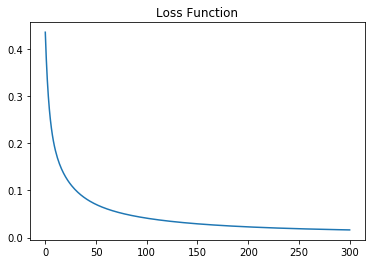

In [0]:
plt.title("Loss Function")
plt.plot(mse_history)
plt.show()

### 정답과 비교하여 완벽하게 예측하진 못하지만, 어느정도 근사하는것을 볼 수 있다.

In [0]:
new_W = weight_history[-1]
y_pred = np.matmul(X,new_W)

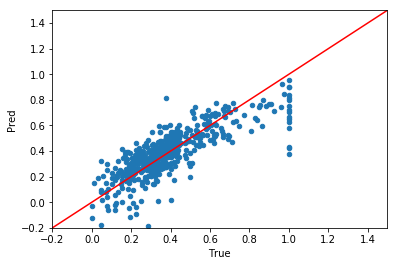

In [0]:
result_df = pd.DataFrame(np.concatenate([y,y_pred], axis=1),
                         columns=['True','Pred'])

result_df.plot('True','Pred',kind='scatter',
               xlim=[-0.2,1.5],ylim=[-0.2,1.5])
plt.plot([-0.2,1.5],[-0.2,1.5],color='r')
plt.show()